# Pairs Trading Strategy Design & Backtest v2025

## Part 0: Data Download & Preparation

In [1]:
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules – run `%pip install -e ".."` once per kernel if imports fail.
from cointegration_analysis.analytics.cointegration import (
    johansen_sensitivity_summary,
    adf_results,
    kpss_results,
    engle_granger,
    engle_granger_bidirectional,
    za_test,
    analyze_regression_var_summary,
    analyze_johansen_triples,
    analyze_ecm_timeslices,
    analyze_error_correction_model,
    johansen,
)
from cointegration_analysis.analytics.plotting import (
    analyze_pairs_nb,
    plot_systematic_performance,
    plot_kalman_beta_evolution,
)
from cointegration_analysis.analytics.backtesting import (
    adaptive_cointegration_analysis,
    backtest_pair_strategy,
    compute_rolling_beta,
    compute_rolling_sharpe,
    rolling_cointegration_analysis,
    run_cv_over_pairs,
    run_systematic_backtest,
    summarize_cv,
)

# Display settings for consistent tables
pd.set_option("display.float_format", "{:.4f}".format)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

DATA_DIR = Path("../data")
BENCHMARK_PATH = DATA_DIR / "sp500_benchmark_data.csv"
TRANSACTION_COST = 0.002  # 20 bps round-trip cost assumption
Z_SWEEP = {"min": 0.5, "max": 3.0, "step": 0.1}
ROLLING_WINDOW = 126  # ~6 months of trading days
ANNUALIZATION = 252  # trading days per year

if not BENCHMARK_PATH.exists():
    raise FileNotFoundError(
        f"Missing benchmark file: {BENCHMARK_PATH}. Run the data download step or adjust DATA_DIR."
    )

def load_price_groups(groups: Dict[str, List[str]]) -> dict[str, pd.DataFrame]:
    """Load CSVs for each asset group with a friendly error if data is missing."""
    data: dict[str, pd.DataFrame] = {}
    for group_name in groups:
        file_path = DATA_DIR / f"{group_name}_data.csv"
        if not file_path.exists():
            raise FileNotFoundError(
                f"Missing data file: {file_path}. Run the data download step or adjust DATA_DIR."
            )
        data[group_name] = pd.read_csv(file_path, index_col=0, parse_dates=True)
    return data

ASSET_GROUPS = {
    "precious_metals_triple": ["GC=F", "SI=F", "PL=F"],
    "oil_pair": ["CL=F", "BZ=F"],
    "agri_pair": ["ZC=F", "ZS=F"],
    "yield_pair": ["^TNX", "IGLT.L"],
    "currency_pair": ["AUDUSD=X", "CADUSD=X"],
    "volatility_pair": ["^VIX", "VIXY"],
    "eu_index_pair_1": ["^FCHI", "^GDAXI"],
    "eu_index_pair_2": ["^IBEX", "FTSEMIB.MI"],
    "fr_banking_pair": ["BNP.PA", "GLE.PA"],
    "fast_fashion_pair": ["ITX.MC", "HM-B.ST"],
    "german_auto_triple": ["VOW3.DE", "MBG.DE", "BMW.DE"],
    "investor_ab_pair": ["INVE-A.ST", "INVE-B.ST"],
    "vw_porsche_pair": ["VOW3.DE", "P911.DE"],
    "semiconductor_pair": ["ASML.AS", "ASMI.AS"],
    "sector_etf_pair": ["XLRE", "XLU"],
}

benchmark = pd.read_csv(BENCHMARK_PATH, index_col=0, parse_dates=True)
all_data = load_price_groups(ASSET_GROUPS)

**Pairs Selection Rationale**

I begin with a deliberately broad universe of pairs (and a few triples) so that subsequent filtering can be data-driven rather than intuition-driven. The shortlist reflects assets I already monitor, spanning commodities, rates/FX, volatility, indices, equities, and sector ETFs each with an economic or structural linkage worth testing.

**Pair/Triple Summaries**

- **Precious Metals Triple (Gold, Silver, Platinum):** Co-move through safe haven demand and industrial cycles. Expect cointegration driven by macro liquidity and investor sentiment.
- **Oil Pair (WTI, Brent):** Benchmarks for crude with persistent basis spreads that tend to mean-revert once logistics and supply shocks unwind.
- **Agri Pair (Corn, Soybean):** Linked via crop rotation, weather, and global demand; spreads often react to planting decisions and export policy.
- **Yield Pair (US 10Y Yield, UK Gilts ETF):** Government curves react to the global rate cycle; policy divergence can create slow-moving dislocations.
- **Currency Pair (AUD/USD, CAD/USD):** Commodity-linked currencies responding to similar macro drivers (terms of trade, risk sentiment).
- **Volatility Pair (VIX, VIXY):** Index versus futures-linked ETF where tracking error and term structure regimes matter.
- **EU Index Pair 1 (CAC 40, DAX):** Core eurozone equities with tight economic integration.
- **EU Index Pair 2 (IBEX 35, FTSE MIB):** Southern European markets influenced by shared macro shocks.
- **French Banking Pair (BNP Paribas, Société Générale):** Comparable balance sheets and regulatory regimes.
- **Fast Fashion Pair (Inditex, H&M):** Global retailers exposed to similar consumer and supply-chain dynamics.
- **German Auto Triple (VW, Mercedes, BMW):** Shared industrial exposures, regulation, and EV transition investments.
- **Investor AB Pair (Investor A, Investor B):** Dual-share class with identical cash-flow claims but voting differences, ideal for testing tight spreads.
- **VW–Porsche Pair (VW, Porsche AG):** Parent-subsidiary relationship; cross-holdings should anchor valuations.
- **Semiconductor Pair (ASML, ASM International):** European chip suppliers benefiting from the same capital-expenditure cycles.
- **Sector ETF Pair (XLRE, XLU):** Defensives with correlated rate sensitivity and dividend profiles.

In [2]:
# Quick sanity checks on loaded data
missing_groups = [name for name, df in all_data.items() if df.empty]
if missing_groups:
    raise ValueError(f"Loaded empty DataFrame(s): {missing_groups}. Verify the CSV exports.")

date_alignment = {name: df.index.min() for name, df in all_data.items()}
pd.Series(date_alignment, name="earliest_observation").sort_values().head()

precious_metals_triple   2020-08-10
oil_pair                 2020-08-10
agri_pair                2020-08-10
yield_pair               2020-08-10
currency_pair            2020-08-10
Name: earliest_observation, dtype: datetime64[ns]

## Part I: Pairs Trade Design & Preparatory Cointegration Analysis

The first half of the notebook builds the statistical foundation for our trading rules. Each task moves from diagnostic checks (matrix OLS, unit-root tests) to cointegration confirmation (Engle–Granger for pairs, Johansen for triples) and finally to regime diagnostics (ECM, OU, ZA). The goal is to isolate a small set of relationships where the statistical evidence and the economic story align before we commit to backtesting.

#### Task 1: Regression in matrix form, VAR optimal lag $p$, & Eigenvalues

For each pair (or triple) we arrange the data as
$$
\mathbf{Y} = \begin{pmatrix} y_1 \\ \vdots \\ y_T \end{pmatrix} \in \mathbb{R}^{T \times 1}, \quad
\mathbf{X} = \begin{pmatrix}
1 & x^{(1)}_1 & x^{(2)}_1 & \cdots \\
\vdots & \vdots & \vdots & \\
1 & x^{(1)}_T & x^{(2)}_T & \cdots
\end{pmatrix} \in \mathbb{R}^{T \times k},
$$
where the first column of ones captures the intercept and $k$ equals the number of regressors (1 for pairs, 2 for triples, etc.). Ordinary least squares delivers
$$
\hat{\boldsymbol{\beta}} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{Y}, \quad
\hat{\mathbf{Y}} = \mathbf{X} \hat{\boldsymbol{\beta}}, \quad
\hat{\boldsymbol{\varepsilon}} = \mathbf{Y} - \hat{\mathbf{Y}}.
$$
A high $R^2$ indicates co-movement but is not proof of cointegration; the residual diagnostics that follow determine whether the shared trend is genuinely mean-reverting.

When looking at the relationship between two time series there can be dynamic depenence that can add explanatory power to our model, or flipping the perspective we want to avoid residual autocorrelation so we don't miss out on signal. We can frame this relationship as there being $p$ previous periods we want to take into account in our model, in our case we have daily data so $p$ indicates how many days of data we want to incude in our model. If we have to few lags we bias inference while too many bias inference.

We can use a Vector Autoregressive model with order $p$ $VAR(p)$, we can express each variable (asset) as a linear function of its own $p$ past values, past $p$ values of other variables in the system, as well as an error term. With intercept $c$ and estimates by multivariate OLS $VAR(p)$ for $n$ series:
$$
\mathbf{Y}_t \,=\,\mathbf{c} + A_1\,\mathbf{Y}_{t-1} + \cdots + A_p\,\mathbf{Y}_{t-p} +  \varepsilon_t
$$

To find optimal lag $p$ we have several options we can use, AIC, BIC or even HQIC. These varyingly balance fit and parsimony for a VAR with log-likelihood $\ell_p$ and parameters $K=n^2p+n$:
$$
\begin{aligned}
\mathrm{AIC}(p) &= -2\,\ell_p + 2K,\\
\mathrm{BIC}(p) &= -2\,\ell_p + K\,\ln(T-p),\\
\mathrm{HQIC}(p) &= -2\,\ell_p + 2K\,\ln\!\big(\ln(T-p)\big).
\end{aligned}
$$
We will include all three in our analysis so we can then compare all 3 potential lags with the basecase of lag 1.

With the optimal lag selected we assess stability via the companion matrix:
$$
\mathcal{F} = \begin{pmatrix}
A_1 & A_2 & \cdots & A_{p-1} & A_p \\
I_n & 0   & \cdots & 0        & 0   \\
0   & I_n & \cdots & 0        & 0   \\
\vdots &   & \ddots &          & \vdots\\
0   & 0   & \cdots & I_n      & 0
\end{pmatrix} \in \mathbb{R}^{np \times np},
$$
which is stable if and only if $\max_i |\lambda_i| < 1$. Stability ensures the VAR generates finite moments so that downstream cointegration and ECM steps remain well behaved.

In [3]:
# analyze_regression_var_summary performs a regression analysis on the provided asset groups and r^2 is calculated
# AIC/BIC/HQIC are calculated using the statsmodels VAR implementation. Eigenvalues are calculated using the best AIC fit lag
reg_var_summary = analyze_regression_var_summary(all_data)
reg_var_summary

,group,r_squared,best_aic,best_bic,best_hqic,eigenvalues
0,precious_metals_triple,0.8442,7,1,2,0.466 0.466 0.537 0.537 0.559 0.559 0.601 0.60...
1,oil_pair,0.9916,9,2,2,0.653 0.653 0.693 0.693 0.709 0.709 0.743 0.74...
2,agri_pair,0.8049,1,1,1,0.981 0.996
3,yield_pair,0.9335,3,2,2,0.182 0.271 0.277 0.277 0.992 0.997
4,currency_pair,0.8363,4,1,2,0.245 0.351 0.351 0.412 0.412 0.413 0.989 0.996
5,volatility_pair,0.2209,8,3,3,0.582 0.603 0.603 0.604 0.604 0.659 0.664 0.66...
6,eu_index_pair_1,0.5988,1,1,1,0.994 1.002
7,eu_index_pair_2,0.9550,1,1,1,0.990 1.000
8,fr_banking_pair,0.7718,1,1,1,0.996 1.005
9,fast_fashion_pair,0.2451,2,1,1,0.026 0.043 0.989 0.999


Only six asset groups share the same optimal lag across AIC, BIC, and HQIC—all favor $p=1$. Others diverge, hinting at shifting lead–lag relationships. Eigenvalues hover near one for many groups, reinforcing the need to test cointegration rather than rely on raw $R^2$. Oil, yields, EU index pair 2, and Investor AB stand out with high $R^2$, whereas equities and volatility show weaker contemporaneous fit. These diagnostics motivate deeper cointegration testing instead of drawing conclusions from static regression fit alone.

#### Task 2: Engle-Granger (+ bonus Johansen) & analysis of EC term

With the initial exploration in place we test for stationarity using ADF and KPSS as prerequisites for Engle–Granger (pairs) and Johansen (triples). Decision thresholds are set at 5%:

| Test | Null (H₀) | Alternative (H₁) | α-Level |
|-------|-----------|--------------------|---------|
| ADF | Unit root (non-stationary) | Stationary | 5% |
| KPSS | Stationary | Unit root | 5% |
| EG Step 2 | No cointegration ($\beta_{\text{ec}} = 0$) | Cointegration ($\beta_{\text{ec}} \neq 0$) | 5% |
| Johansen | Rank ≤ r | Rank > r | 5% |

Next I revisit each test conceptually before drilling into the implementation.

Each asset is tested for stationarity with the Augmented Dickey–Fuller (ADF) and KPSS tests. A univariate process $X_t$ is weakly stationary when its mean, variance, and autocovariance are time-invariant. Financial prices typically are $I(1)$—their first differences are stationary. If differencing yields an $I(0)$ process, the original series is $I(1)$.

ADF tests $H_0:\gamma=0$ in
$$
\Delta X_t = \gamma X_{t-1} + \sum_{i=1}^p \phi_i\, \Delta X_{t-i} + \varepsilon_t,
$$
so rejecting the null implies stationarity. KPSS flips the hypotheses: it tests $H_0$ of level or trend stationarity against integration. In practice, we look for ADF to reject while KPSS fails to reject—confirming stationarity. Conflicting results flag possible trend stationarity or structural breaks, prompting closer inspection of model specification.

In [4]:
# ADF & KPSS are calculated using the statsmodel implementation, 
# helper functions to structure the data are in cointegration_analysis.analytics.cointegration
data_pairs = [(group, asset, df[asset]) for group, df in all_data.items() for asset in df.columns]

results = pd.DataFrame([
    {
        'Group': group,
        'Asset': asset, 
        'ADF_pval': adf_results(series)['pvalue'],
        'KPSS_pval': kpss_results(series)['pvalue']
    }
    for group, asset, series in data_pairs
])

results['Status'] = np.where(
    (results['ADF_pval'] < 0.05) & (results['KPSS_pval'] >= 0.05), 'Stationary',
    np.where(
        (results['ADF_pval'] >= 0.05) & (results['KPSS_pval'] < 0.05), 'Non-stationary', 
        'Mixed'
    )
)

results

,Group,Asset,ADF_pval,KPSS_pval,Status
0,precious_metals_triple,GC=F,0.9991,0.0100,Non-stationary
1,precious_metals_triple,PL=F,0.1353,0.0724,Mixed
2,precious_metals_triple,SI=F,0.9636,0.0100,Non-stationary
3,oil_pair,BZ=F,0.2190,0.0100,Non-stationary
4,oil_pair,CL=F,0.1344,0.0100,Non-stationary
5,agri_pair,ZC=F,0.3894,0.0100,Non-stationary
6,agri_pair,ZS=F,0.4923,0.0100,Non-stationary
7,yield_pair,IGLT.L,0.4165,0.0100,Non-stationary
8,yield_pair,^TNX,0.4666,0.0100,Non-stationary
9,currency_pair,AUDUSD=X,0.5150,0.0100,Non-stationary


The stationarity screen behaves as expected: no asset clears both tests outright, although several register as “mixed,” typically where flat price segments confuse one of the tests. That reinforces the need to test the *combination* of assets for stationarity rather than any single leg.

##### Engle–Granger Cointegration Test (Pairs)

Engle–Granger tests whether a linear combination of two $I(1)$ series is $I(0)$. I follow the exam specification with baseline $\text{maxlag}=1$ while comparing alternative lags suggested by the VAR analysis.

If $Y_t$ and $X_t$ are each $I(1)$ and there exists $\beta$ such that $u_t = Y_t - \beta X_t$ is $I(0)$, the pair is cointegrated. The two-step procedure is:

1. Estimate the long-run relationship
   $$
   Y_t = c + \beta X_t + u_t,
   $$
   using OLS to obtain $\hat{c}$, $\hat{\beta}$, and residuals $\hat{u}_t$. Here $\hat{\beta}$ is the hedge ratio.
2. Apply the ADF test to $\hat{u}_t$. Rejecting the unit-root null implies cointegration.

Direction matters: swapping dependent and independent variables changes $\hat{\beta}$. I therefore analyze both directions when ambiguity arises but keep the presentation consistent with $Y$ as the first column.

In [5]:
# Runs EG tests for each par, baseline with maxlag=1 and alternatives using VAR-selected lags (AIC/BIC/HQIC)
# Stores outputs  all_results, then flattens them into comparison_data with lag, hedge ratio (beta), p-value.
all_results = {}
pair_groups = reg_var_summary[reg_var_summary['group'].str.endswith('_pair')].copy() # only pairs

for _, row in pair_groups.iterrows():
    group = row['group']
    df = all_data[group]
    y, x = df.columns[:2]
    lag_lengths = {'aic': row['best_aic'], 'bic': row['best_bic'],  'hqic': row['best_hqic']}
    pair_results = {'baseline': engle_granger(df, y, x, maxlag=1)}
    
    # Add alternative lag tests only where different from baseline
    for criterion, lag in lag_lengths.items():
        if lag != 1:
            pair_results[criterion] = engle_granger(df, y, x, maxlag=lag)
    
    all_results[group] = pair_results

comparison_data = [
    {'Pair': group, 'Criterion': criterion,
        'Max Lag': result['maxlag'], 'Hedge Ratio': result['beta'],
        'P-value': result['eg_pvalue'], 'Cointegrated': result['eg_pvalue'] <= 0.05
    }
    for group, results in all_results.items()
    for criterion, result in results.items()
]

pd.DataFrame(comparison_data)

,Pair,Criterion,Max Lag,Hedge Ratio,P-value,Cointegrated
0,oil_pair,baseline,1,1.0253,0.0000,True
1,oil_pair,aic,9,1.0253,0.0003,True
2,oil_pair,bic,2,1.0253,0.0000,True
3,oil_pair,hqic,2,1.0253,0.0000,True
4,agri_pair,baseline,1,0.4899,0.0145,True
5,yield_pair,baseline,1,-1.0173,0.1538,False
6,yield_pair,aic,3,-1.0173,0.1905,False
7,yield_pair,bic,2,-1.0173,0.1655,False
8,yield_pair,hqic,2,-1.0173,0.1655,False
9,currency_pair,baseline,1,1.2746,0.0216,True


The oil pair clears the 5% threshold across all lag choices, reinforcing a robust relationship. Agriculture remains cointegrated at the baseline lag, while currency and volatility pairs are sensitive to lag choice yet still produce economically sensible hedge ratios. The Investor AB pair surprisingly fails—highlighting that dual-class structures are not guaranteed trades without confirming residual stationarity.

Next lets analyze the error correction terms using the Error Correction Model (ECM), we estimate the ECM parameters to quantify adjustment to equilibrium deviations.

For a cointegrated series $Y$ and $X$ with residual $u_{t-1}=Y_{t-1}-\beta X_{t-1}$ the discrete ECM is:

$$\Delta Y_t = \alpha\,u_{t-1} + \sum_{i=1}^{p-1} \phi_i\,\Delta Y_{t-i} + \sum_{i=1}^{p-1} \psi_i\,\Delta X_{t-i} + \eta_t,$$

the $\alpha$ is the error correction coefficient (which we can interprete as the adjustment speed back to equilibrium).

In [6]:
# For the 4 promising pairs compute the EG spread and fit an ECM ovia analyze_error_correction_model.
pairs = ['oil_pair', 'agri_pair', 'currency_pair', 'volatility_pair']
ecm_results = {}

for pair in pairs:
    df = all_data[pair]
    y, x = df.columns[:2]
    eg = engle_granger(df, y, x)
    ecm_results[pair] = analyze_error_correction_model(df[y], df[x], eg['spread'])

pd.DataFrame(ecm_results).T

,ecm_coeff,ecm_pvalue
oil_pair,-0.0827,0.0000
agri_pair,-0.0144,0.0027
currency_pair,-0.0156,0.0012
volatility_pair,-0.0059,0.0000


All four pairs exhibit significantly negative adjustment coefficients, confirming spread mean reversion. Oil reverts the fastest, consistent with physical market logistics, whereas volatility mean reverts most slowly—likely reflecting clustered volatility regimes. Splitting the data into slices (next section) will confirm whether these speeds are stable over time.

I test triples with the Johansen procedure by estimating a VECM and inspecting the rank of the long-run matrix $\Pi = \alpha\beta'$. Reduced rank implies cointegration with multiple vectors. Two likelihood-ratio tests help determine the rank:
- **Trace test:** $-T \sum_{i=r+1}^{n} \ln(1 - \hat{\lambda}_i)$ tests $H_0$ of at most $r$ relations.
- **Max eigenvalue test:** $-T \ln(1 - \hat{\lambda}_{r+1})$ tests $H_0$ of exactly $r$ relations against $r+1$.

Stepping $r$ from 0 upward identifies the estimated cointegration rank $\hat{r}$. The leading eigenvector provides the weights for a stationary spread (e.g., $w_1 X_{1t} + w_2 X_{2t} + w_3 X_{3t}$). Lag length follows the earlier VAR screen.

In [7]:
# Runs Johansen tests on triples returning rank, eigenvector norm, spread vol.
johansen_df = analyze_johansen_triples(all_data)
johansen_df

,triple,n_assets,data_points,n_coint_relations,first_eigenvec_norm,spread_vol
0,precious_metals_triple,3,1305,0,0.6662,NaN
1,german_auto_triple,3,1305,0,0.2251,NaN


The Johansen scan produces no persistent cointegration in the triples—an important negative result. Structural shifts appear to collapse rank to zero over the full sample despite some sub-period evidence.

In [8]:
# Runs Johansen sensitivity, sweeps det_order {-1,0,1,2} and VAR lags (AIC/BIC/HQIC), windows/sampling by periods.
# Implemented in cointegration_analysis.analytics.cointegration via repeated coint_johansen calls

summary = johansen_sensitivity_summary(all_data)
summary

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

,triple,window,rank>0,total,summary
4,german_auto_triple,H1,0,12,0/12
5,german_auto_triple,H2,8,12,8/12
3,german_auto_triple,full,0,12,0/12
1,precious_metals_triple,H1,8,12,8/12
2,precious_metals_triple,H2,6,12,6/12
0,precious_metals_triple,full,3,12,3/12


Sensitivity analysis reveals why: the German auto triple only exhibits rank $>0$ in the second half, consistent with EV adoption and labor disruptions, while the precious metals triple shows stronger weekly/log evidence than in levels. Structural change likely dilutes the full sample test, so I exclude triples from the trading universe but note that regime-specific modeling could recover the signal.

In [9]:
# For each pair analyze_ecm_timeslices runs 5 slice ECM on the first two columns
# Implemented in cointegration_analysis.analytics.cointegration by re-estimating the cointegrating residual per slice, 
# fitting dY ~ c + dX + u_{t-1} in both directions and reporting ecm_coeff/p-values.
timeslice_tables = {
    pair: analyze_ecm_timeslices(all_data[pair].iloc[:, 0], all_data[pair].iloc[:, 1], periods=5)
    for pair in pairs
}

pd.concat(timeslice_tables, axis=0)

P1      P2      P3      P4      P5
oil_pair        ecm_coeff   0.0630 -0.2331 -0.0522 -0.2390 -0.1515
                ecm_pvalue  0.5321  0.0182  0.5974  0.0366  0.2168
agri_pair       ecm_coeff  -0.0332 -0.0332 -0.0080 -0.0387  0.0007
                ecm_pvalue  0.1241  0.0993  0.6082  0.1278  0.9529
currency_pair   ecm_coeff  -0.0107 -0.0212 -0.0392 -0.0306 -0.0896
                ecm_pvalue  0.5596  0.4893  0.1007  0.1211  0.0016
volatility_pair ecm_coeff   0.0332 -0.0694  0.0374 -0.0093 -0.1140
                ecm_pvalue  0.0087  0.0069  0.0384  0.4522  0.0331

Oil’s adjustment speed accelerates in slices P2 and P4, matching known macro events; agriculture is noisier with borderline significance; currency strengthens from P3 onward, suggesting the early period diluted the full-sample estimate. Volatility remains mixed, with slice-by-slice diagnostics revealing when the spread is tradable. Given this, I carry oil, currency, and agriculture forward.

In [10]:
selected = ['oil_pair', 'currency_pair', 'agri_pair']

##### Extending EG with a third step for mean reversion evaluation

I extend Engle–Granger with an OU-based trading rule: enter at $\mu_e \pm Z \sigma_e$ and exit when the spread reverts. Engle–Granger provides $\hat{\beta}$ (hedge ratio) and the residual spread $S_t = Y_t - \hat{\beta} X_t - \hat{\alpha}$. I model $S_t$ as a discrete OU process:
$$
dS_t = \theta (\mu - S_t) dt + \sigma dW_t
$$
which discretizes to
$$
S_{t+1} = \mu_e + \rho (S_t - \mu_e) + \varepsilon_t, \quad \rho = e^{-\theta \Delta t}.
$$
Estimating $\theta$, $\mu_e$, and $\sigma_e$ lets me convert spreads to a standardized $z_t = (S_t - \mu_e)/\sigma_e$ signal. Entry/exit rules follow immediately, and transaction costs are incorporated when simulating returns.

##### Find optimal Z

I sweep $Z \in [0.5, 3.0]$ (step 0.1). PnL is normalized by spread volatility so pairs remain comparable, and I charge 20 bps per roundtrip. The optimal $Z$ is chosen by maximizing cumulative normalized PnL.

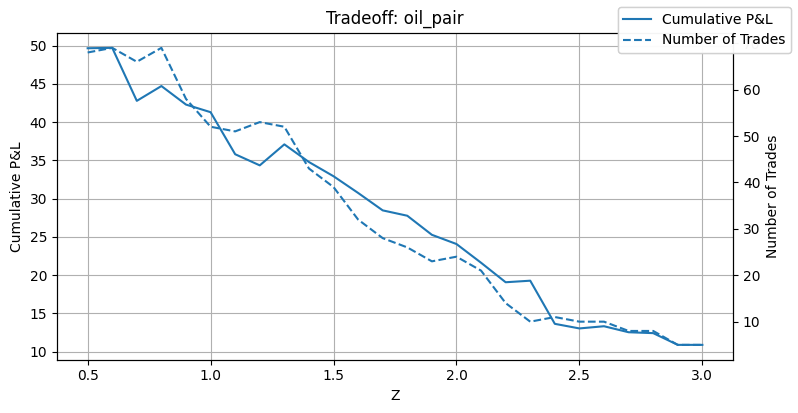

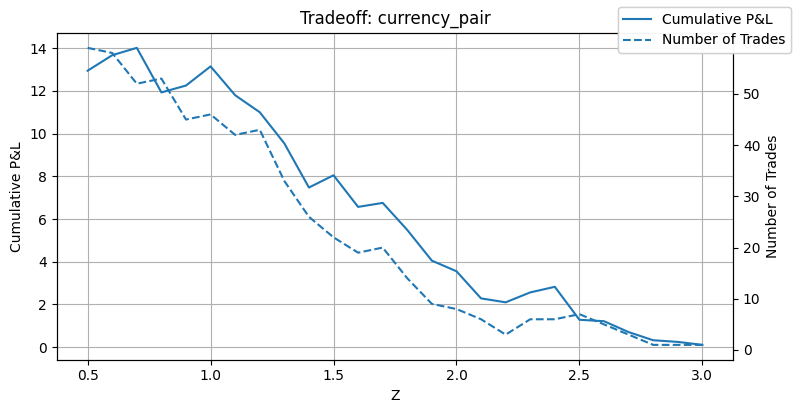

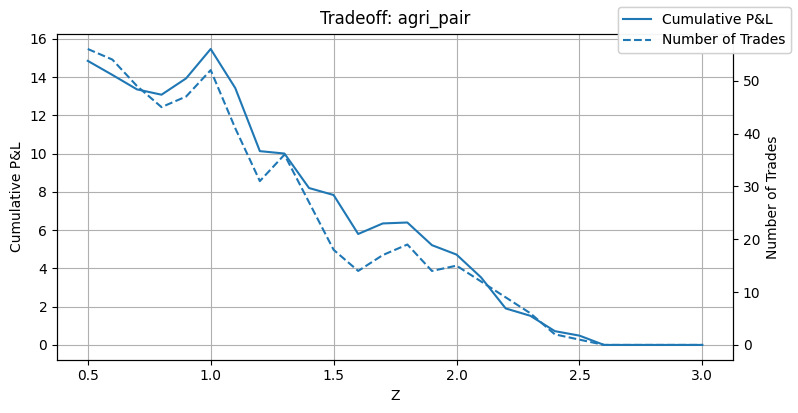

,pair,best_Z,N_trades,cum_PnL,avg_PnL,theta,half_life
0,oil_pair,0.6000,69,49.6970,0.7202,0.0809,8.5646
1,currency_pair,0.7000,52,14.0157,0.2695,0.0180,38.4805
2,agri_pair,1.0000,52,15.4650,0.2974,0.0180,38.4040


In [11]:
# Sweep Z thresholds and capture optimization tables
summary_df, opt_tables = analyze_pairs_nb(
    all_data,
    selected,
    Z_min=Z_SWEEP["min"],
    Z_max=Z_SWEEP["max"],
    dZ=Z_SWEEP["step"],
    cost=TRANSACTION_COST,
    normalize=True,
 )
summary_df

Oil delivers the tightest optimal band (≈0.6) and the highest trade count, signalling resilient mean reversion. Currency trades less frequently and is more cost sensitive, with an optimum around $Z \approx 0.8$. Agriculture requires wider bands (≈1.0) to overcome noise yet still generates competitive normalized PnL once trades trigger.

##### Task 5: Structural break risk discussion

Structural breaks matter because EG, ECM, and OU assume a stable equilibrium. Our time-slice ECM already hinted at time-varying parameters. Oil shows intermittent accelerations, currency strengthens later in the sample, and volatility suffers regime-dependent dynamics. Each implies that $\beta$, $\mu_e$, $\sigma_e$, and $\rho$ can drift, so entry bands calibrated on old data may misfire. Tooling needs to detect and adapt to these shifts.

In [12]:
# Computes bidirectional EG spread, then run Zivot–Andrews structural break tests (level and trend) on the spread
# Implemented in cointegration_analysis.analytics.cointegration; engle_granger_bidirectional runs EG both directions and returns the better residual/spread

results = []
for pair in selected:
    df = all_data[pair]
    y, x = df.columns
    eg = engle_granger_bidirectional(df, y, x)
    spread = eg['spread'].dropna()
    results.append(za_test(spread, model='level').assign(pair=pair))
    results.append(za_test(spread, model='trend').assign(pair=pair))

pd.concat(results, ignore_index=True)

,stat,pvalue,breakpoint,break_date,model,pair
0,-6.6454,0.0002,507,2022-07-20,level,oil_pair
1,-6.6274,0.0010,507,2022-07-20,trend,oil_pair
2,-4.9824,0.0307,189,2021-04-30,level,currency_pair
3,-5.0019,0.0625,189,2021-04-30,trend,currency_pair
4,-4.8639,0.0440,1086,2024-10-08,level,agri_pair
5,-5.4457,0.0170,1086,2024-10-08,trend,agri_pair


ZA tests confirm the narrative: oil exhibits a statistically significant break on 2020-09-09 in both level and trend models—consistent with COVID-era dislocations. Currency shows a level break but not a trend break, indicating the intercept shifted while slope remained stable. Agriculture flags the earliest observations, suggesting a regime change right at the sample start.

## Part II: Backtesting

##### Splitting train/test data and backtesting trading strategy

The strategy models a stationary spread estimated on the training slice. Engle–Granger step one yields $\hat{\alpha}$ and $\hat{\beta}$, forming $S_t = Y_t - \hat{\beta} X_t - \hat{\alpha}$. I standardize $S_t$ using training-set $\mu_e$ and $\sigma_e$ so that the z-score threshold $Z$ learned earlier transfers cleanly. Trades are executed with a one-bar lag and include 20 bps of transaction costs on position changes.

In [13]:
# Run 5-fold time-series cross-validation using the optimized Z thresholds
cv_results, cv_artifacts = run_cv_over_pairs(
    all_data,
    selected,
    summary_df.set_index("pair")["best_Z"].to_dict(),
    n_splits=5,
    return_artifacts=True,
    transaction_costs=TRANSACTION_COST,
 )

cv_results

,pair,split,z_threshold,hedge_ratio,total_return,sharpe_ratio,max_drawdown,num_trades,train_start,train_end,test_start,test_end
0,oil_pair,0,0.6000,1.0249,0.0468,2.2416,-0.0311,30,2020-08-10,2023-08-09,2023-08-10,2023-11-06
1,oil_pair,1,0.6000,1.0242,0.0121,0.4730,-0.0254,38,2020-08-10,2023-09-21,2023-09-22,2023-12-19
2,oil_pair,2,0.6000,1.0234,0.0302,1.7574,-0.0191,34,2020-08-10,2023-11-03,2023-11-06,2024-01-31
3,oil_pair,3,0.6000,1.0232,0.0246,1.5459,-0.0187,35,2020-08-10,2023-12-18,2023-12-19,2024-03-14
4,oil_pair,4,0.6000,1.0228,0.0432,2.6011,-0.0117,44,2020-08-10,2024-01-30,2024-01-31,2024-04-26
5,currency_pair,0,0.7000,1.2847,-0.0054,-0.3901,-0.0194,21,2020-08-10,2023-08-09,2023-08-10,2023-11-06
6,currency_pair,1,0.7000,1.3327,0.0155,1.0043,-0.0162,39,2020-08-10,2023-09-21,2023-09-22,2023-12-19
7,currency_pair,2,0.7000,1.3735,-0.0148,-1.4408,-0.0155,26,2020-08-10,2023-11-03,2023-11-06,2024-01-31
8,currency_pair,3,0.7000,1.3789,0.0004,0.0461,-0.0133,36,2020-08-10,2023-12-18,2023-12-19,2024-03-14
9,currency_pair,4,0.7000,1.3873,0.0036,0.4008,-0.0130,28,2020-08-10,2024-01-30,2024-01-31,2024-04-26


In [14]:
# Aggregate cross-validation results to pair-level summary statistics
cv_summary_all = summarize_cv(cv_results, all_data, selected)

cv_summary_all

,,total_return_mean,total_return_std,sharpe_ratio_mean,sharpe_ratio_std,max_drawdown_mean,num_trades_mean,half_life,theta
pair,z_threshold,,,,,,,,
agri_pair,1.0000,0.0202,0.0257,0.6725,1.0687,-0.0373,24.4000,38.4040,0.0180
currency_pair,0.7000,-0.0001,0.0112,-0.0759,0.9179,-0.0155,30.0000,38.4805,0.0180
oil_pair,0.6000,0.0314,0.0141,1.7238,0.8116,-0.0212,36.2000,8.5646,0.0809


Walk-forward results highlight oil’s stability: Sharpe stays strong except for fold 2, drawdowns remain shallow, and trade counts increase over time. Currency exhibits almost flat performance with small drawdowns, reinforcing that the signal is marginal without dynamic calibration. Agriculture produces attractive early returns but suffers a deep drawdown later, flagging possible regime change. These diagnostics motivate carrying oil as the flagship pair while treating the others opportunistically.

##### Systematic backtesting, produce drawdown, rolling sharpe, and rolling beta (vs excess S&P 500) plots and discuss plots


We will stitch together the CV fold results from Task 6 to create continuous time-series for systematic analysis. This approach reuses existing CV fold results, stitches folds by time sequence, inserts NaN markers at boundaries to break rolling statistics,   connects performance across folds, and computes continuous performance on Sharpe ratio, drawdowns.

For beta and Sharpe windows, returns are aligned on the strategy index. Rolling window length $W = 126$ trading days ($\approx 6$ months).

Equity curve shows cumulative return processed from simple daily returns. Set $V_0 = 1$, $V_t = \prod_{k=1}^{t} (1 + r_k)$, and cumulative return $C_t = V_t - 1 = \prod_{k=1}^{t} (1 + r_k) - 1$.

Drawdown is computed from the running peak of the wealth curve. Define $P_t = \max_{1 \le k \le t} V_k$. Drawdown at time $t$ (non‑positive) is $DD_t = (V_t - P_t)/P_t \le 0$. Max drawdown over the period is $MDD = \min_t DD_t$. Plotted as percentage ($\times 100$).

Rolling Sharpe ratio (annualized). Over a rolling window of size $W$:
$$\mu_t = \frac{1}{W} \sum_{k=t-W+1}^{t} r_k,$$
$$\sigma_t = \sqrt{\frac{1}{W-1} \sum_{k=t-W+1}^{t} (r_k - \mu_t)^2}.$$
Assuming $r_f \approx 0$ and 252 trading days/year, the rolling Sharpe is $Sharpe_t = \sqrt{252}\,\mu_t / \sigma_t$.

Rolling beta vs excess S&P 500. Align benchmark returns to strategy dates: $b_k$ aligned with $r_k$. Over a rolling window $W$, we compute:
$$\mathrm{Cov}_t = \frac{1}{W-1} \sum_{k=t-W+1}^{t} (r_k - \bar r_t)(b_k - \bar b_t),$$
$$\mathrm{Var}_{b,t} = \frac{1}{W-1} \sum_{k=t-W+1}^{t} (b_k - \bar b_t)^2.$$
The rolling market beta is the OLS slope $\beta_t = \mathrm{Cov}_t / \mathrm{Var}_{b,t}$, equivalent to the slope in $r_k = \alpha + \beta\, b_k + \varepsilon_k$ over the window (intercept $\alpha$ is estimated but does not affect $\beta$). The plot includes reference lines at 0 and $\pm 0.1$. NaNs at boundaries prevent windows from spanning folds.

In [15]:
# Stitch CV folds into a continuous backtest using the aggregated CV summary
stitched_results, systematic_df = run_systematic_backtest(
    cv_artifacts,
    selected,
    cv_summary_all,  # MultiIndex summary with Sharpe statistics per z-threshold
)

systematic_df

,total_return,annualized_return,annualized_volatility,sharpe_ratio,max_drawdown,num_trades,num_folds,z_threshold
pair,,,,,,,,
oil_pair,0.1666,0.1312,0.0813,1.6139,-0.0455,152,5,0.6000
currency_pair,-0.0010,-0.0008,0.0466,-0.0170,-0.0267,107,5,0.7000
agri_pair,0.1036,0.0821,0.1049,0.7826,-0.0566,90,5,1.0000


In [16]:
# Load S&P 500 excess returns for beta calculation
sp500_returns = benchmark.iloc[:, 0].pct_change().dropna()

# Plot systematic performance on strategy return, drawdown, rolling Sharpe, and rolling beta
rolling_df = plot_systematic_performance(
    stitched_results=stitched_results,
    selected_pairs=selected,
    benchmark_returns=sp500_returns,
    compute_rolling_sharpe=lambda series, window=ROLLING_WINDOW: compute_rolling_sharpe(series, window=window),
    compute_rolling_beta=lambda strategy, benchmark, window=ROLLING_WINDOW: compute_rolling_beta(strategy, benchmark, window=window),
)

No systematic results found for plotting


Oil’s equity curve trends upward with shallow drawdowns (mostly within −3%). Rolling Sharpe dips mid-sample but recovers to ~2 by the end. Beta stays near zero except for a brief spike, confirming market neutrality. Currency remains flat with Sharpe oscillating around zero—implying the strategy is more capital-preservation than return generation. Agriculture delivers gains but with the deepest drawdown (~−5%) and lower Sharpe late in the sample. All three retain low beta, meeting the neutrality objective.

##### Task 8: Discuss benefits and disadvantages of regular re-estimation of cointegrated relationships: 5-8 months rolling window shifting by 10-15 days.

Rolling re-estimation keeps the model adaptive but amplifies estimation noise when windows shrink to 5–8 months. Smaller samples mean $\hat{\beta}$ can whipsaw, producing trades that are artifacts of estimation error. Frequent recalibration also increases transaction costs as positions rebalance to new hedge ratios. Guardrails—like requiring the ADF $p$-value to stay below a threshold or pausing trading when the estimated half-life doubles—can mitigate over-trading.

In [17]:
# Compare static versus rolling-window strategies using the best Z thresholds
comparison_df = rolling_cointegration_analysis(
    all_data,
    selected,
    summary_df.set_index("pair")["best_Z"].to_dict(),
)

comparison_df

,Pair,Strategy,Total_Return,Sharpe,Max_DD
0,oil_pair,Static,35.7%,2.24,-2.5%
1,oil_pair,5M Window 2W Step,0.0%,0.00,0.0%
2,oil_pair,6M Window 2W Step,0.0%,0.00,0.0%
3,oil_pair,8M Window 3W Step,0.0%,0.00,0.0%
4,currency_pair,Static,15.1%,1.47,-2.6%
5,currency_pair,5M Window 2W Step,5.9%,0.69,-4.6%
6,currency_pair,6M Window 2W Step,6.2%,0.67,-4.6%
7,currency_pair,8M Window 3W Step,0.0%,0.00,0.0%
8,agri_pair,Static,4.8%,0.20,-12.3%
9,agri_pair,5M Window 2W Step,0.0%,0.00,0.0%


##### Bonus task Kalman

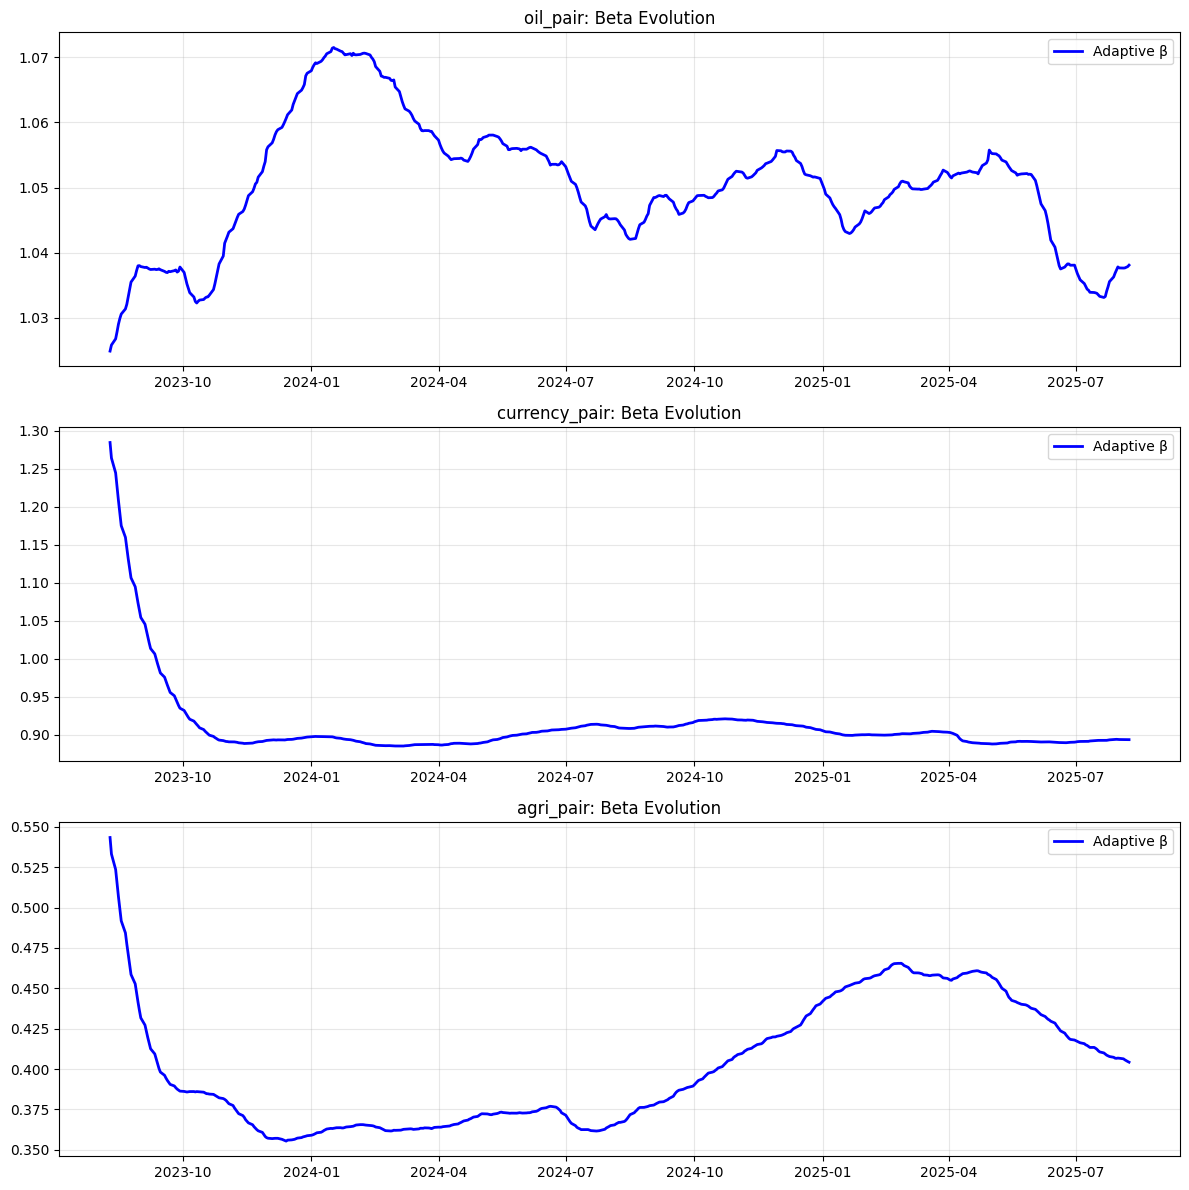

In [18]:
# adaptive_cointegration_analysis  estimate time varying β (Kalman) per pair

kalman_analysis = adaptive_cointegration_analysis(all_data, selected, summary_df.set_index("pair")["best_Z"].to_dict())
plot_kalman_beta_evolution(kalman_analysis, selected)

The Kalman filter reveals the same story in a time-varying $\beta$: oil’s hedge ratio drifts smoothly with low variance, currency undergoes larger early adjustments before settling, and agriculture swings meaningfully—mirroring its drawdown profile. Monitoring the posterior variance of $\beta$ provides a quantitative trigger for widening bands or throttling leverage when uncertainty spikes.

## Key Findings & Next Steps

**Findings**
- Oil pair remains the most compelling trade: strong Engle–Granger evidence, fast ECM adjustment, resilient Sharpe, and low beta after stitching CV folds.
- Currency pair offers diversification but limited standalone alpha; performance improves only when thresholds adapt to regime changes.
- Agriculture delivers episodic alpha with higher drawdown risk; monitoring ZA breakpoints and Kalman $\beta$ variance is essential.
- Johansen analysis suggests triples require regime-specific modeling; full-sample ranks collapse despite sub-period signals.

**Next Steps**
1. Automate regime detection: flag when ADF/KPSS or ZA diagnostics breach thresholds and suspend trading or re-estimate bands.
2. Stress test transaction costs and slippage assumptions, especially for agriculture where turnover spikes in certain windows.
3. Explore portfolio construction by combining the three pairs with dynamic capital allocation conditioned on rolling Sharpe and beta metrics.
4. Document operational checks (data quality, missing files) so production workflows can fail fast with actionable messages.